<a href="https://colab.research.google.com/github/ctrivino1/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
!nvidia-smi

Mon Jan 16 19:24:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |    788MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [123]:
!pip install gdown
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [124]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [125]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 83.4MB/s]


In [126]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [127]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


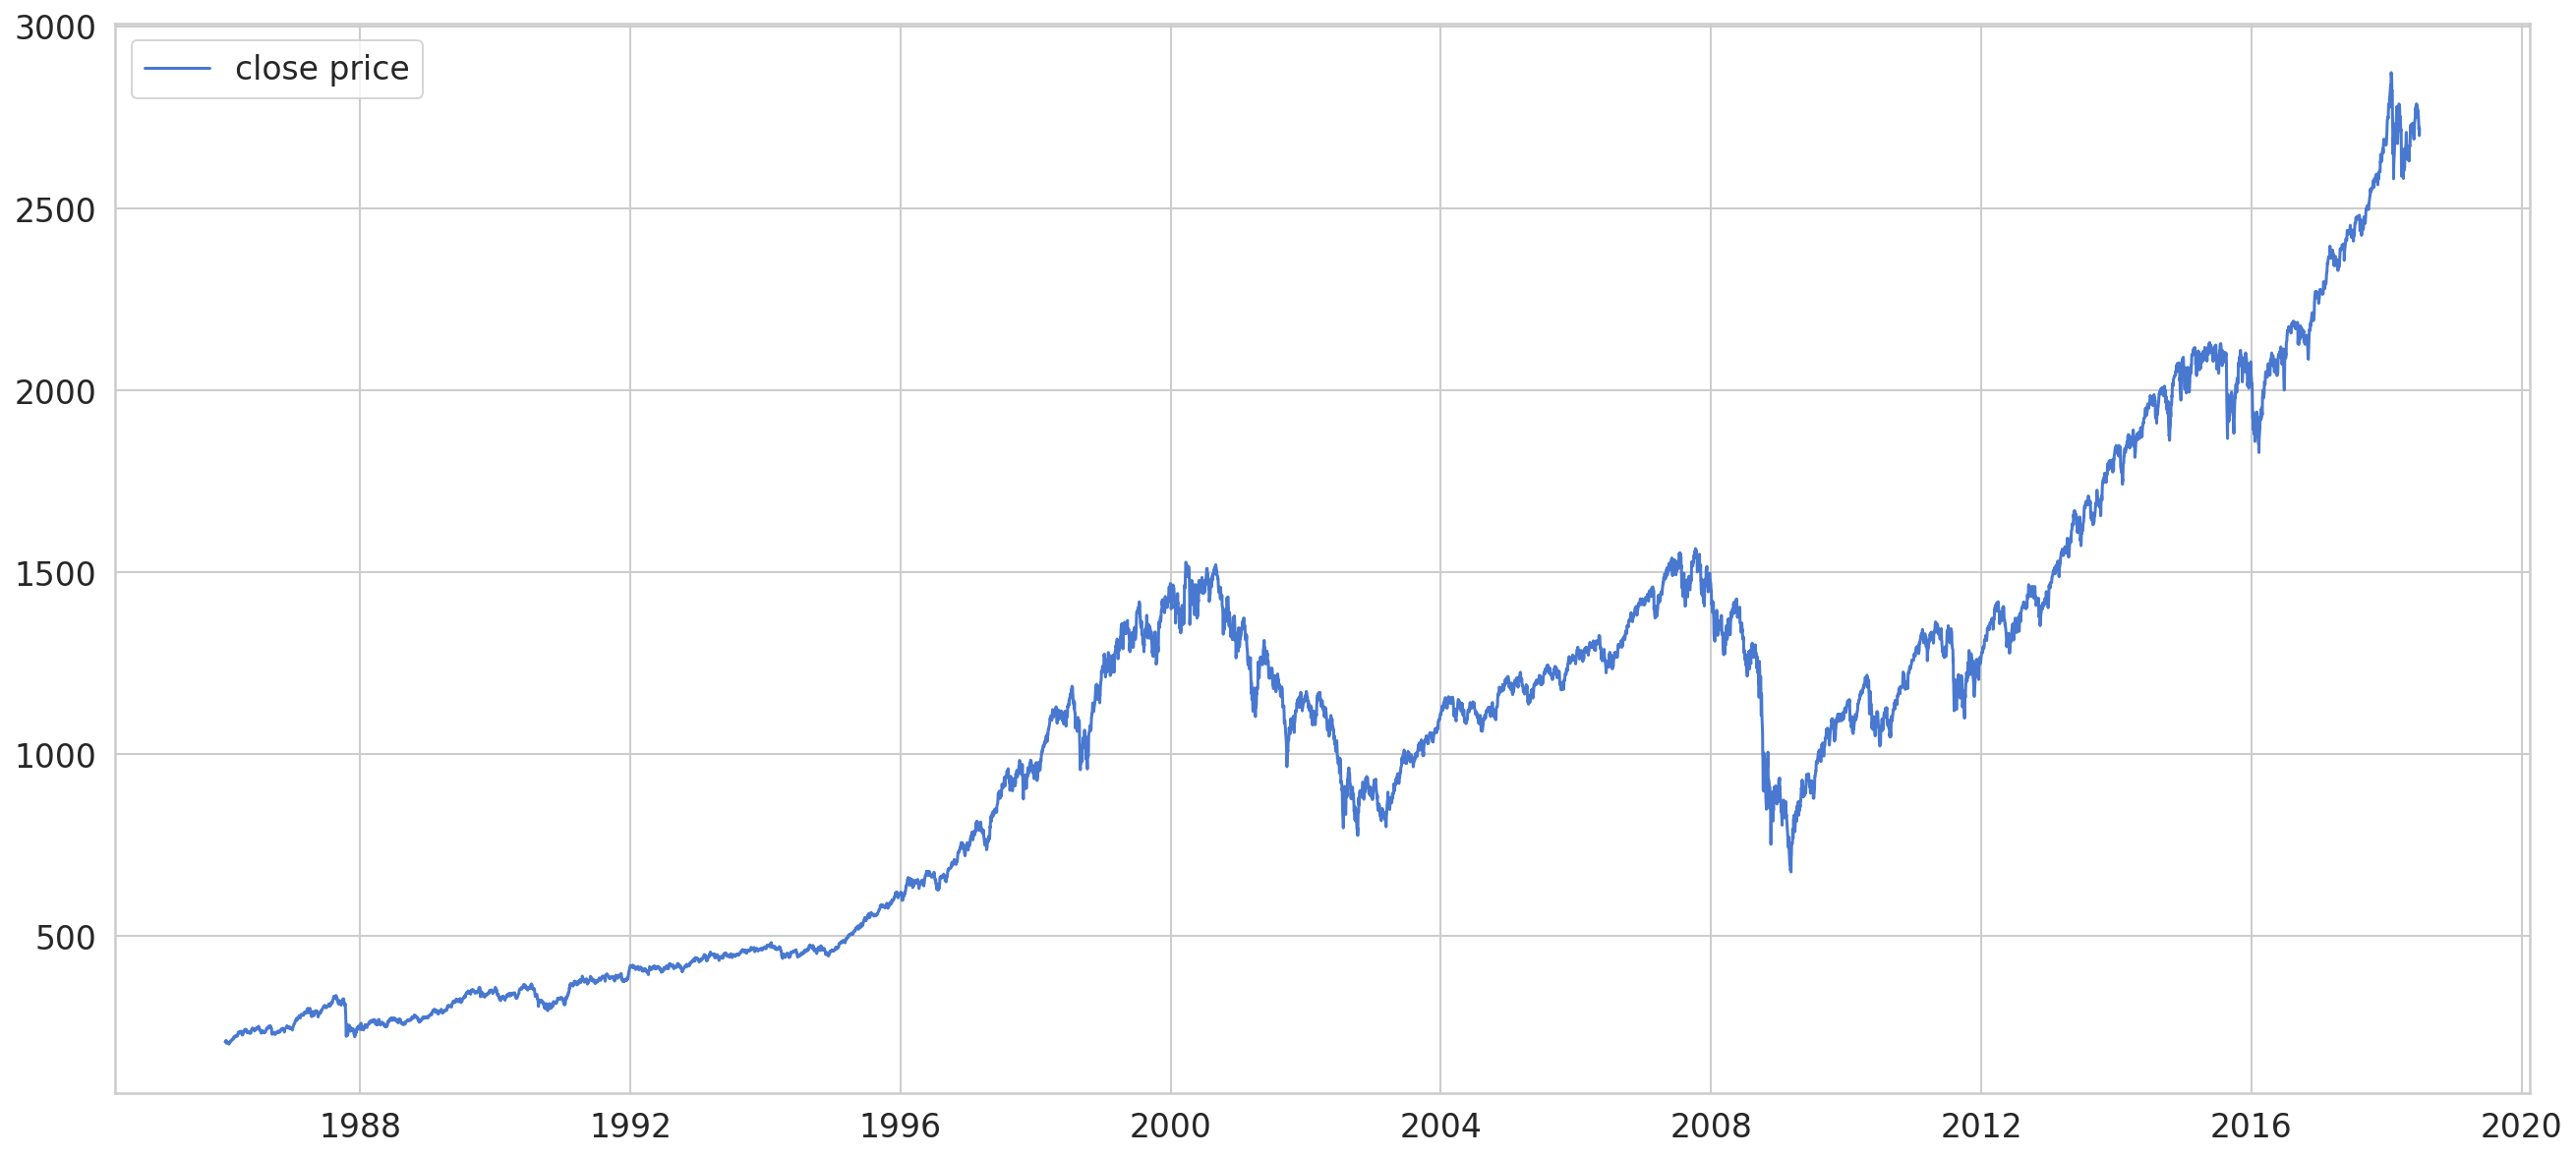

In [128]:
plt.plot(df, label='close price')
plt.legend();

In [129]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [130]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

<ipython-input-130-419ee0323bae>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-130-419ee0323bae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [131]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [132]:
train[['close']].head()

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169


In [133]:
train.close.head

<bound method NDFrame.head of date
1986-01-02   -1.475126
1986-01-03   -1.472703
1986-01-06   -1.473135
1986-01-07   -1.467219
1986-01-08   -1.478169
                ...   
2016-11-04    2.047774
2016-11-07    2.134814
2016-11-08    2.149916
2016-11-09    2.194431
2016-11-10    2.202357
Name: close, Length: 7782, dtype: float64>

In [134]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [135]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [136]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
218/218 [==============================] - 7s 14ms/step - loss: 0.1739 - val_loss: 0.2587
Epoch 2/10
218/218 [==============================] - 2s 10ms/step - loss: 0.1043 - val_loss: 0.2133
Epoch 3/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1032 - val_loss: 0.2077
Epoch 4/10
218/218 [==============================] - 3s 12ms/step - loss: 0.1221 - val_loss: 0.2959
Epoch 5/10
218/218 [==============================] - 2s 10ms/step - loss: 0.1325 - val_loss: 0.3393
Epoch 6/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1174 - val_loss: 0.2418
Epoch 7/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1198 - val_loss: 0.1882
Epoch 8/10
218/218 [==============================] - 3s 12ms/step - loss: 0.1220 - val_loss: 0.1624
Epoch 9/10
218/218 [==============================] - 2s 11ms/step - loss: 0.1281 - val_loss: 0.1244
Epoch 10/10
218/218 [==============================] - 2s 9ms/step - loss: 0.1342 - val_los

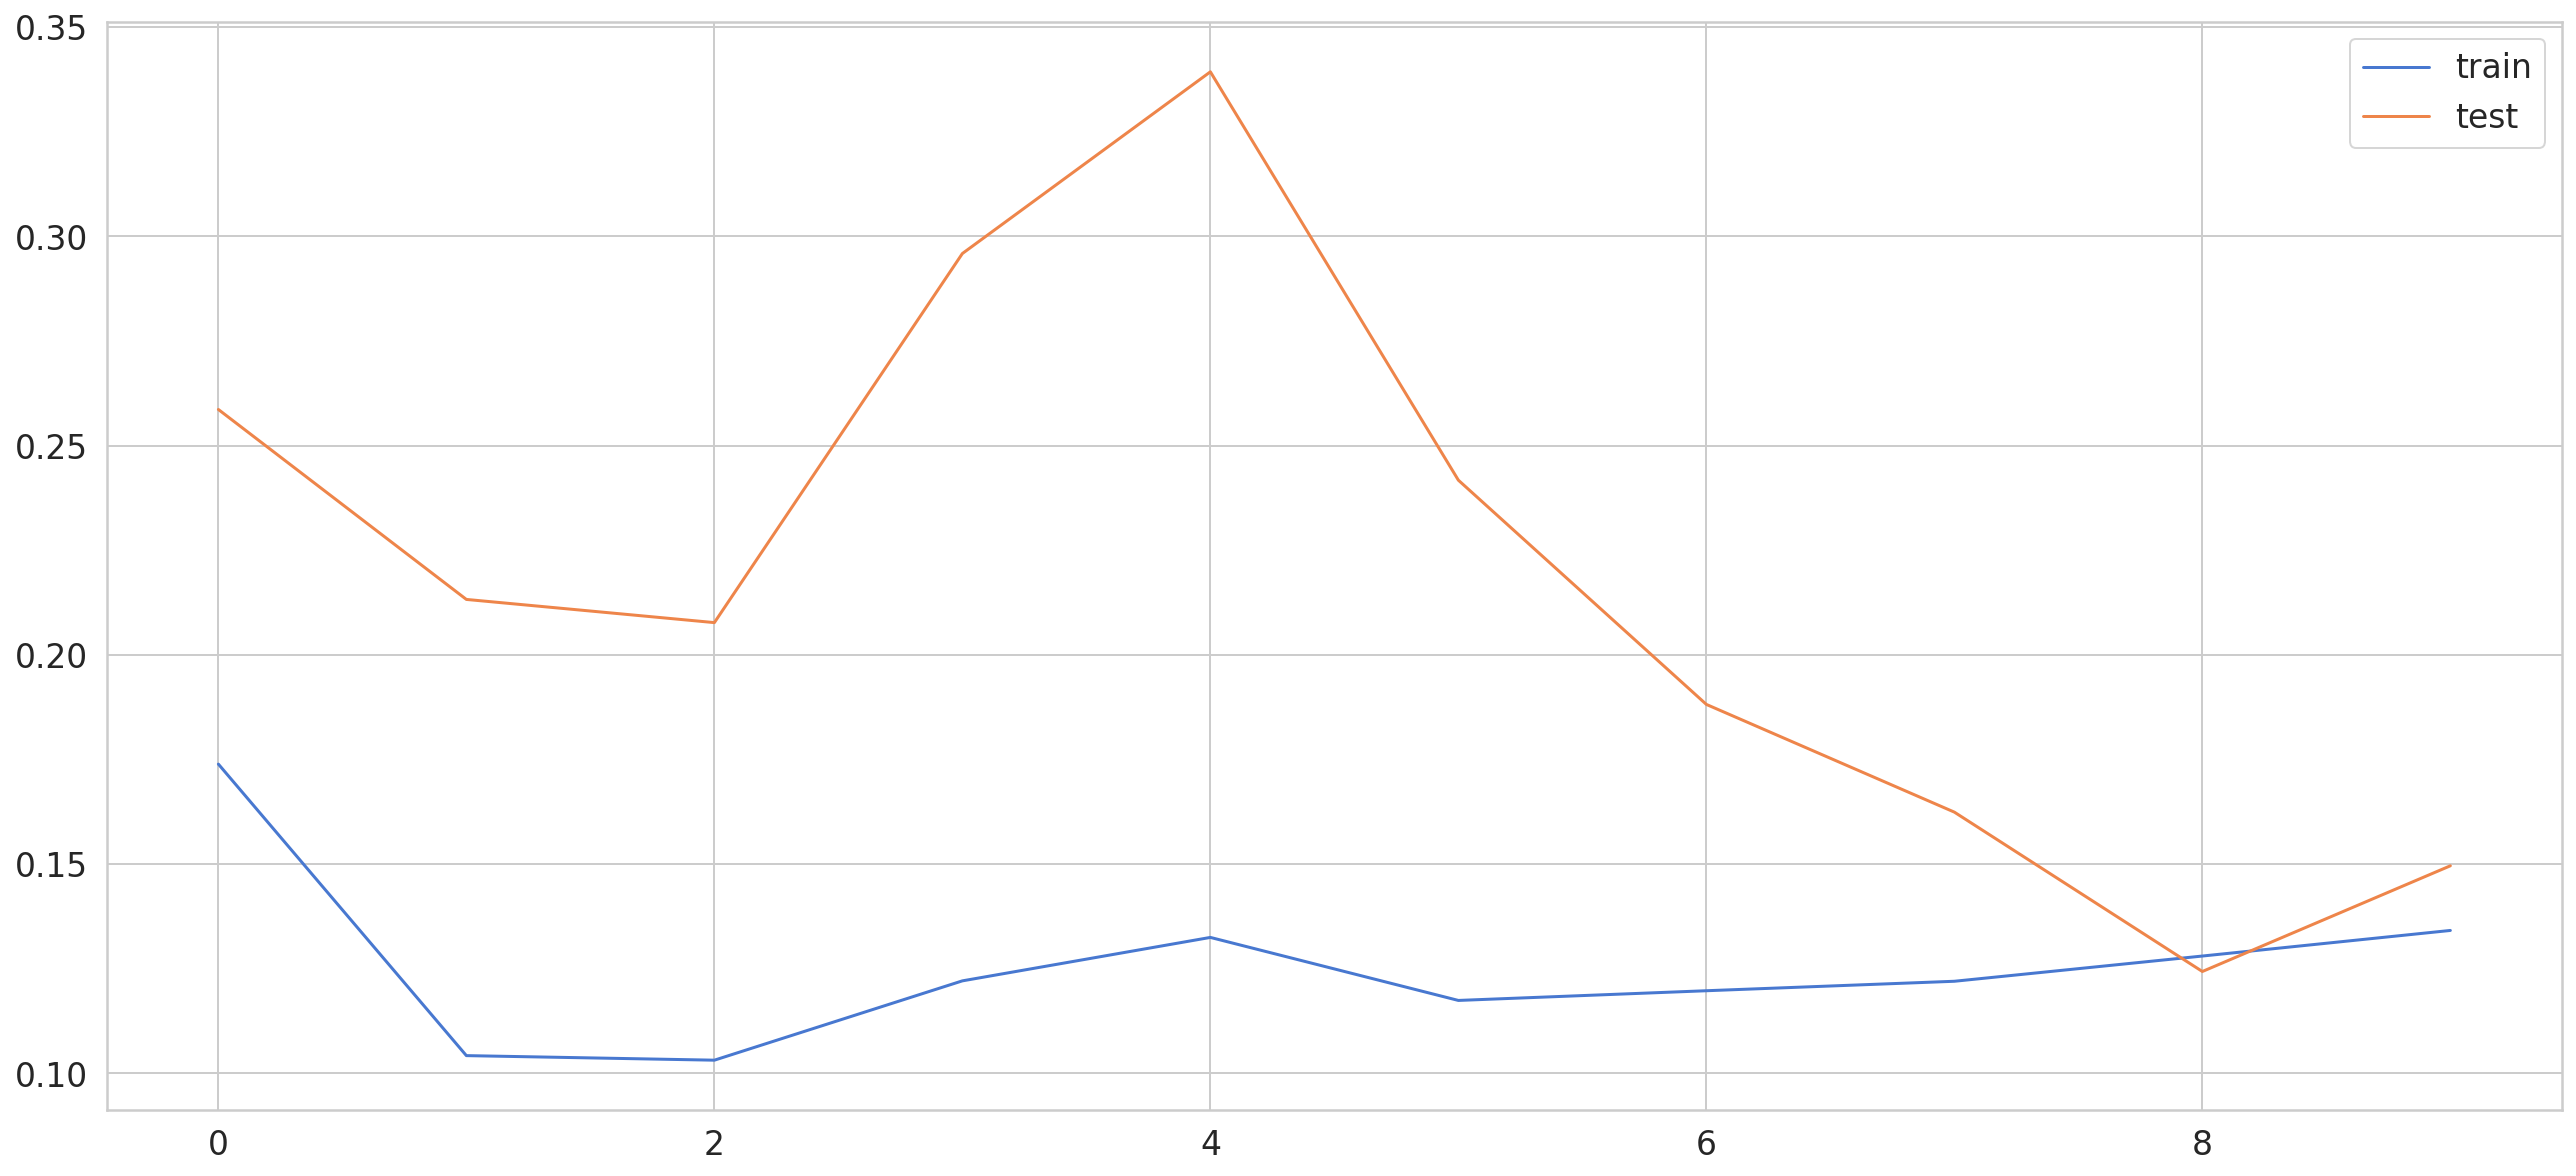

In [137]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [138]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 [==============================] - 1s 3ms/step


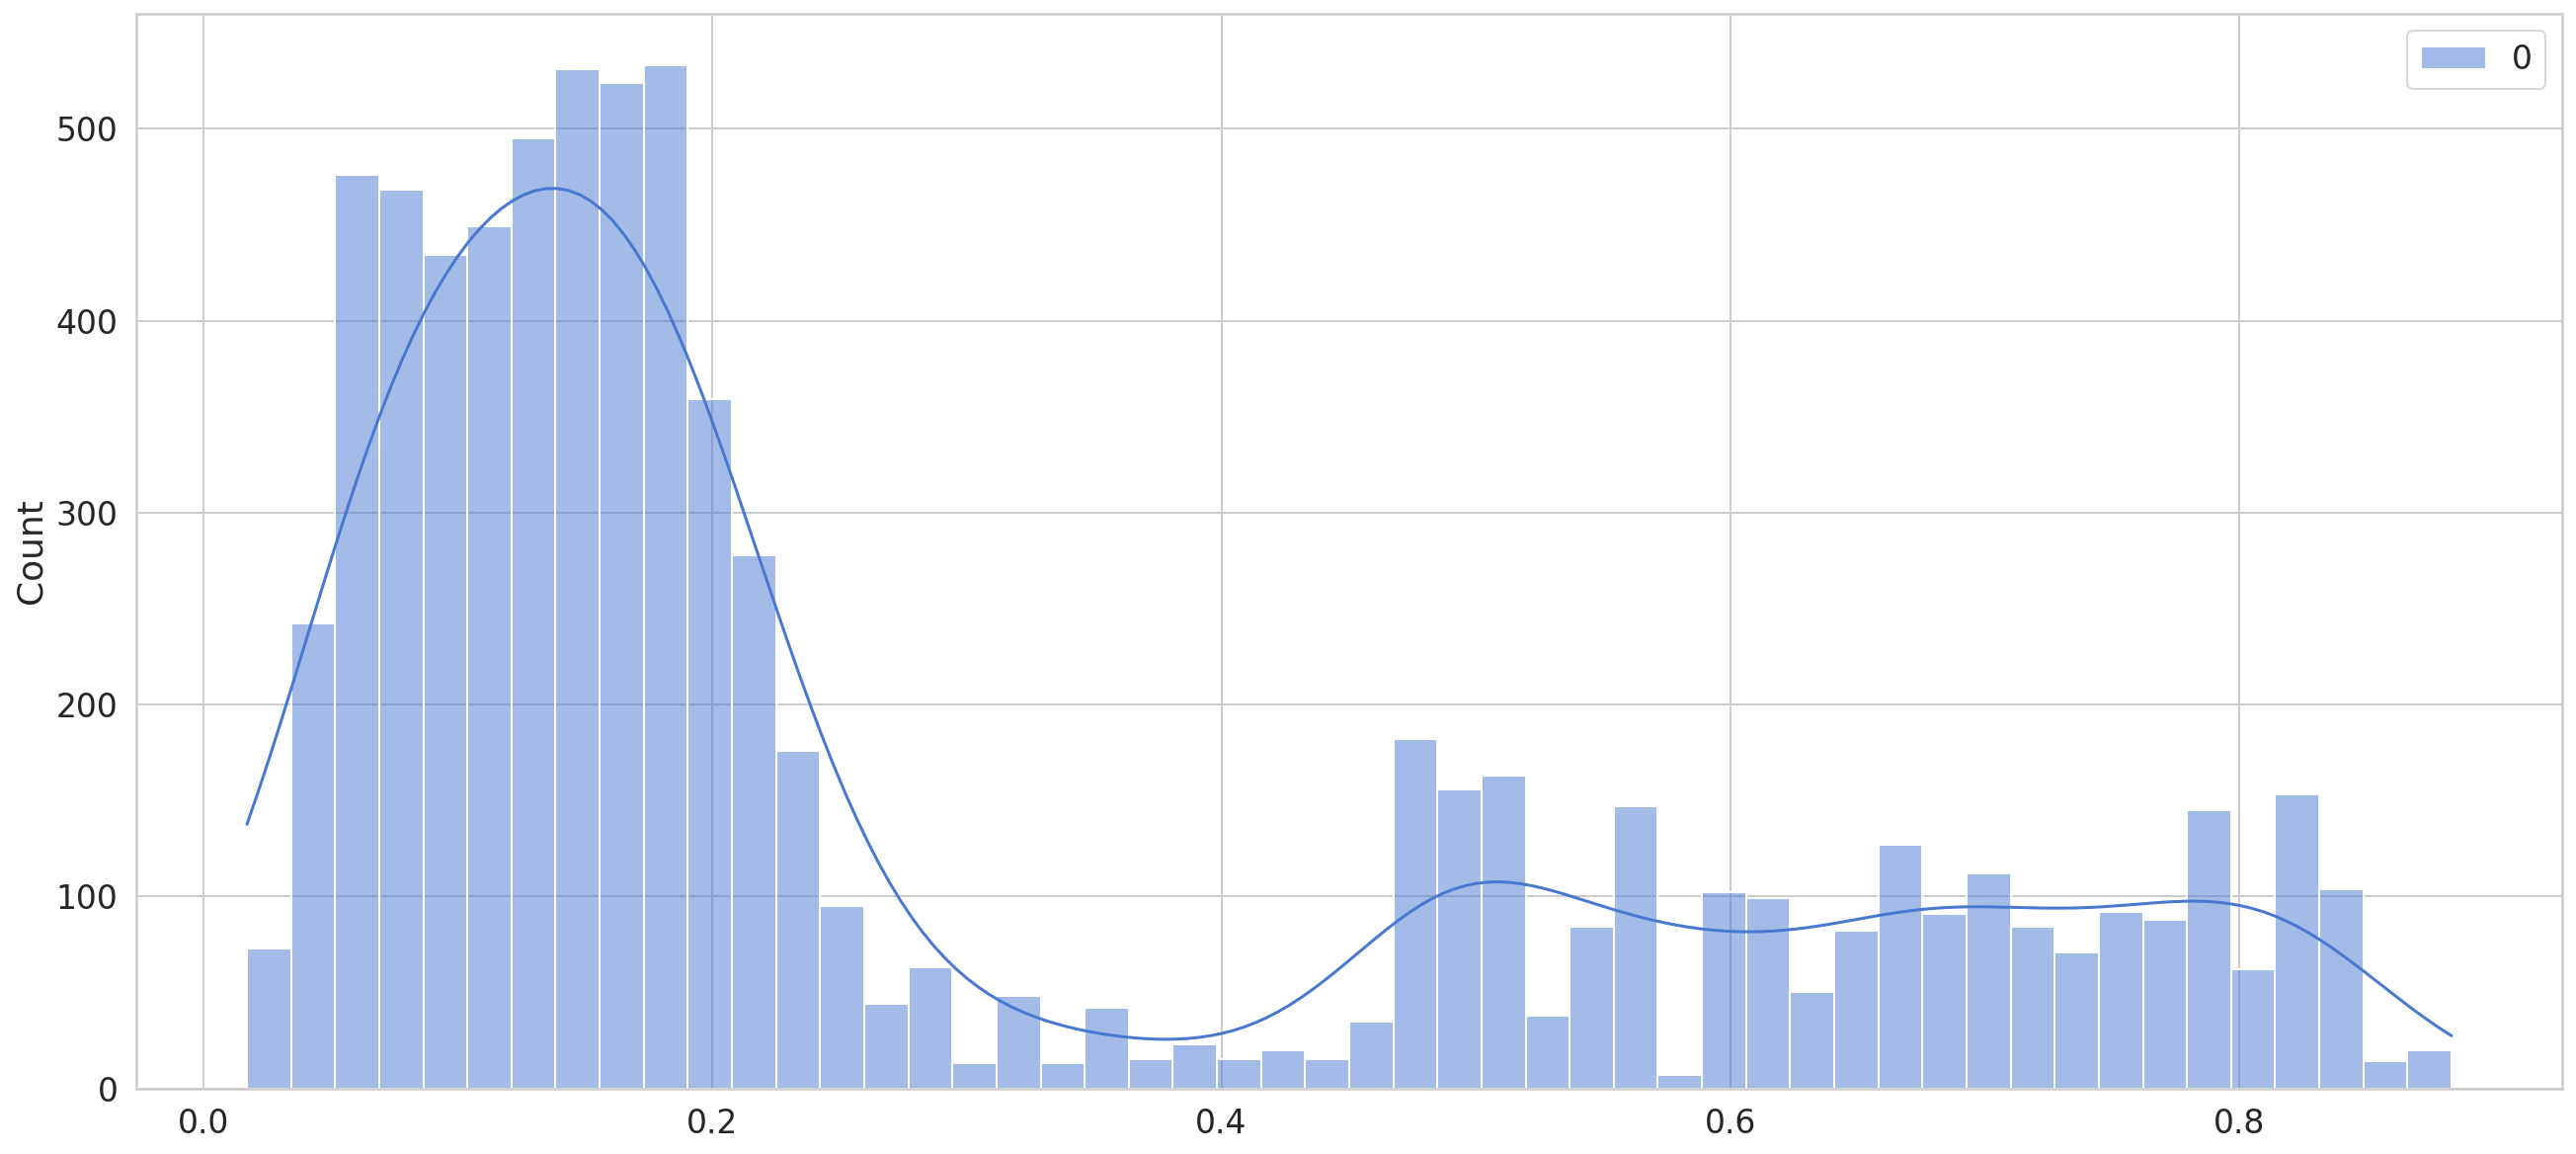

In [139]:
sns.histplot(train_mae_loss, bins=50, kde=True);

In [140]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 0s 4ms/step


In [141]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

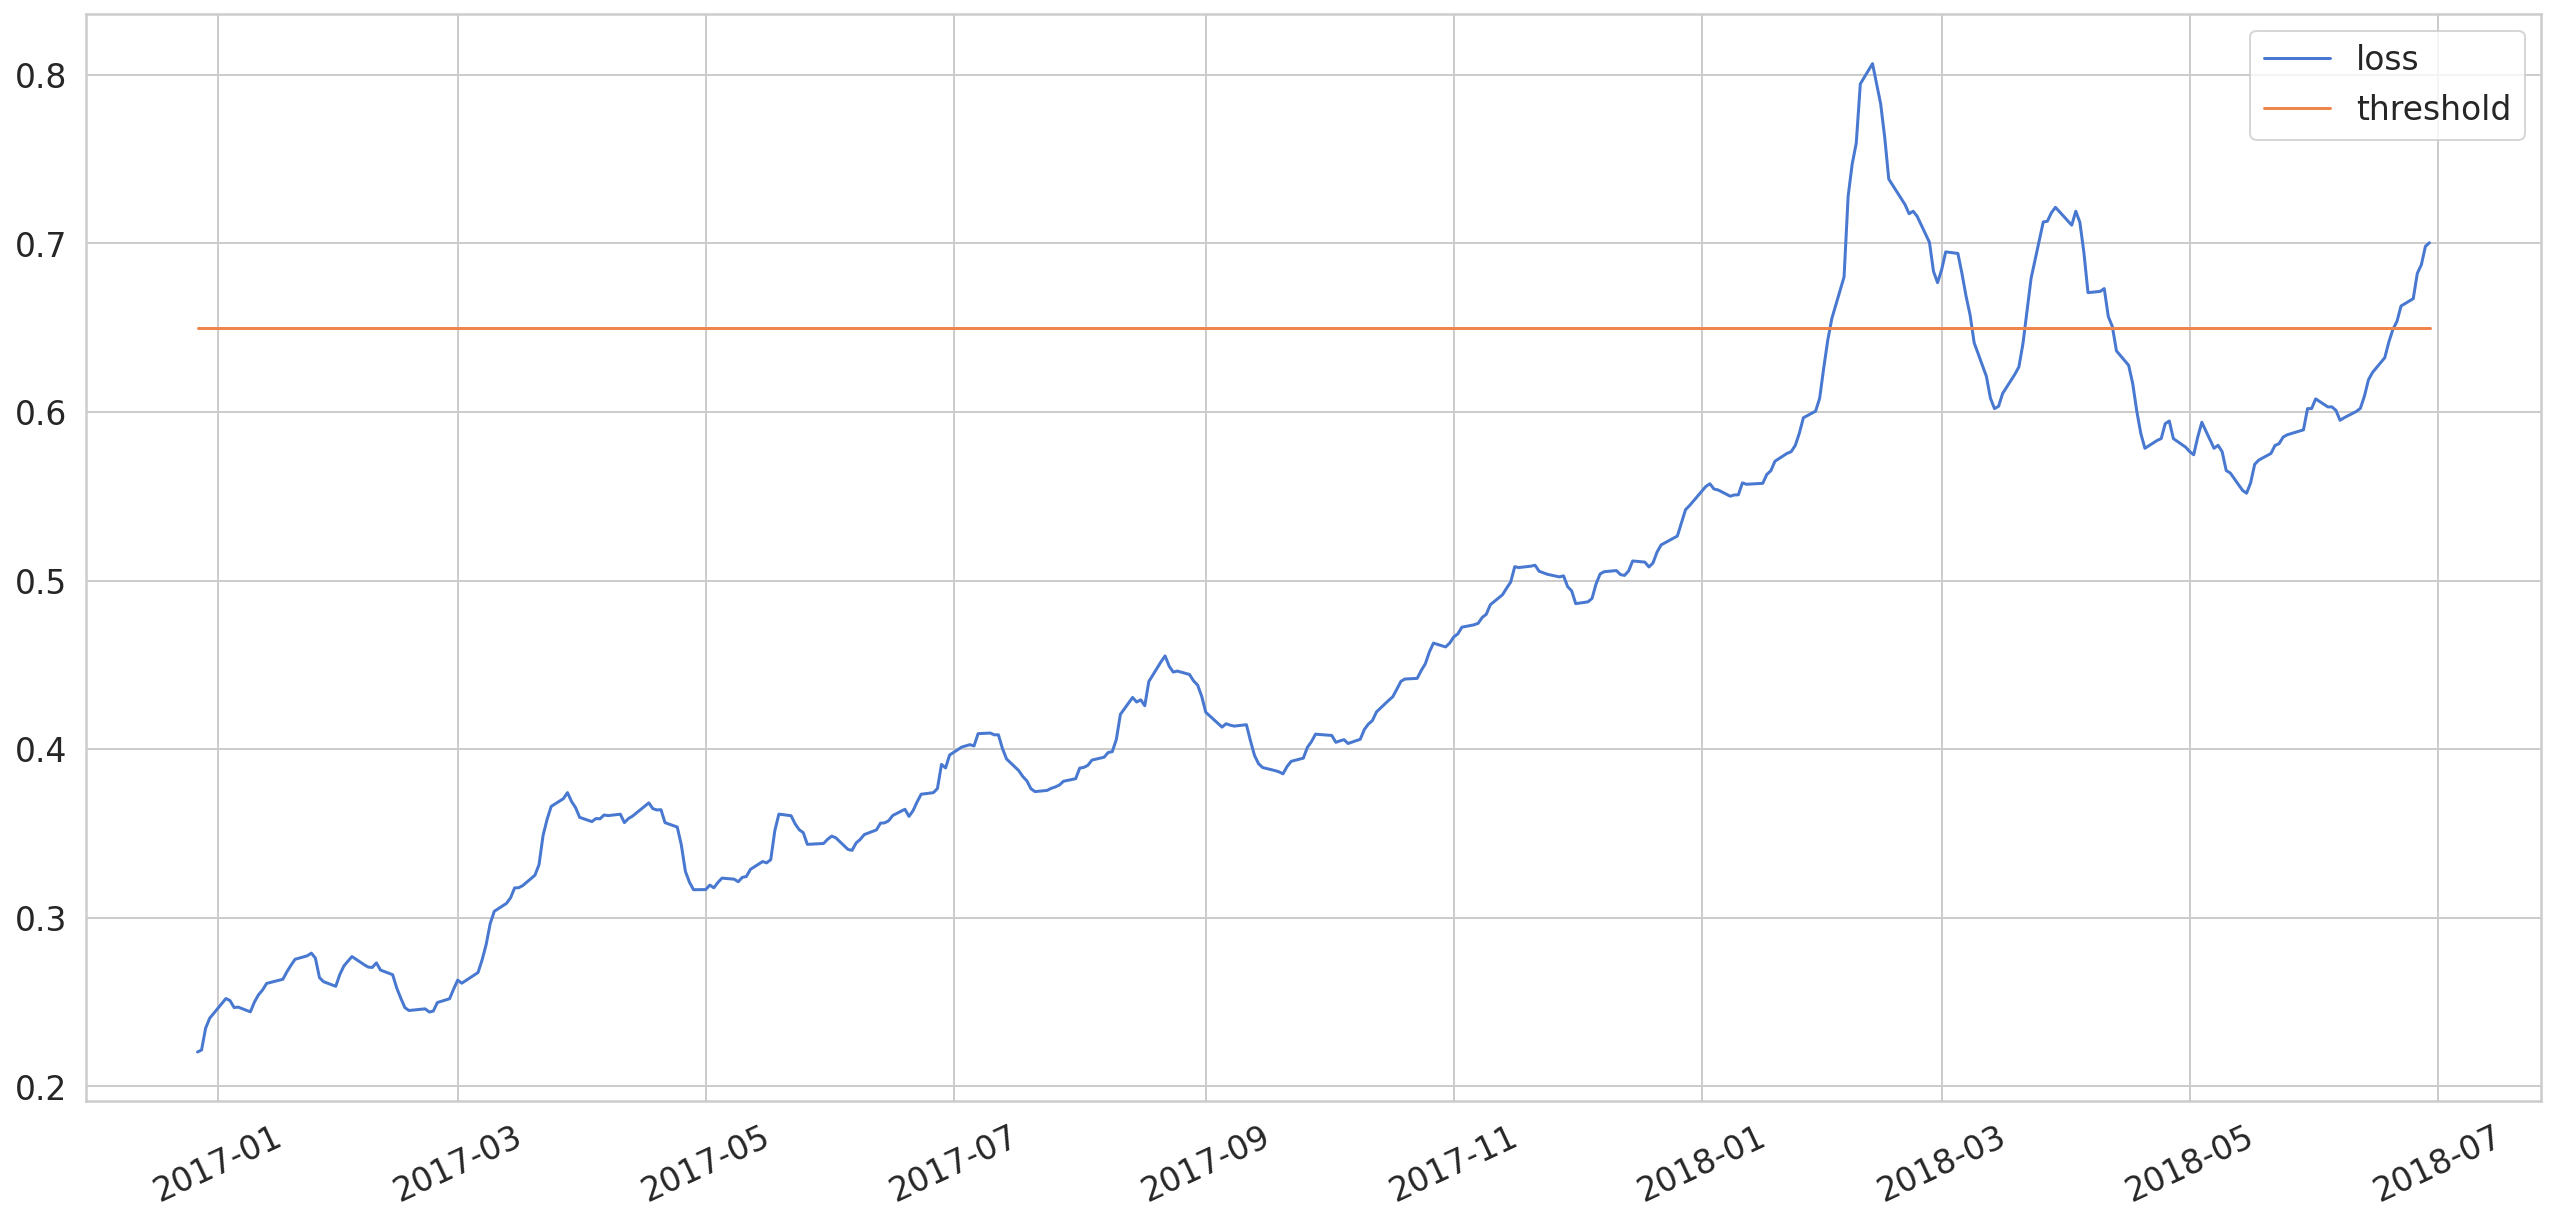

In [142]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [143]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-02,0.655494,0.65,True,3.319282
2018-02-05,0.680096,0.65,True,3.106679
2018-02-06,0.727938,0.65,True,3.193456
2018-02-07,0.747061,0.65,True,3.168136
2018-02-08,0.759451,0.65,True,2.979068


In [144]:
test[TIME_STEPS:].close.array.reshape(-1, 1)

<PandasArray>
[
[2.392815988613518],
[2.3572036233405282],
[2.3559639523974814],
[2.3363733949187213],
[2.3720608917640167],
[2.396328389618818],
[2.3930413833304356],
[2.4080301320054596],
[2.3928535543996707],
[2.3928535543996707],
[2.4049121717547655],
[2.3957461199334475],
[2.4036349350255652],
[2.390956482198947],
[2.3984696394295355],
[2.3830676671068294],
[2.3973802316311],
[2.385903883961376],
[2.4138340459660896],
[2.4482067402960315],
[2.4450324313661076],
[2.4412946356438905],
[2.4153930260914365],
[2.4115800987969123],
[2.412857335526113],
[2.415299111626054],
[2.446422365453767],
[2.437293879418602],
[2.438270589858578],
[2.4412570698577376],
[2.4660504887186794],
[2.4815088097206153],
[2.504330024808528],
[2.5218544640488756],
[2.543774100269118],
[2.5399611729745937],
[2.5473616328467235],
[2.574070906801466],
[2.5692624861738897],
[2.57112199258846],
[2.5777523538444544],
[2.582279031075884],
[2.5708026834061597],
[2.6315089938293155],
[2.6051378119499495],
[2.607391759

In [145]:
test

,close
date,
2016-11-11,2.196666
2016-11-14,2.196197
2016-11-15,2.226606
2016-11-16,2.220126
2016-11-17,2.239247
...,...
2018-06-25,3.234646
2018-06-26,3.245897
2018-06-27,3.201889


In [146]:
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-02,0.655494,0.65,True,3.319282
2018-02-05,0.680096,0.65,True,3.106679
2018-02-06,0.727938,0.65,True,3.193456
2018-02-07,0.747061,0.65,True,3.168136
2018-02-08,0.759451,0.65,True,2.979068


In [147]:
len(anomalies)

46

In [148]:
print( "length:", len(anomalies))
print(scaler.inverse_transform(anomalies.close.array.reshape(-1, 1)).flatten())

length: 46
[2762.13 2648.94 2695.14 2681.66 2581.   2619.55 2656.   2662.94 2698.63
 2731.2  2732.22 2716.26 2701.33 2703.96 2747.3  2779.6  2744.28 2713.83
 2677.67 2691.25 2720.94 2728.12 2726.8  2738.97 2643.69 2588.26 2658.55
 2612.62 2605.   2640.87 2581.88 2614.45 2644.69 2662.84 2604.47 2613.16
 2656.87 2642.19 2663.99 2749.76 2754.88 2717.07 2723.06 2699.63 2716.31
 2718.37]


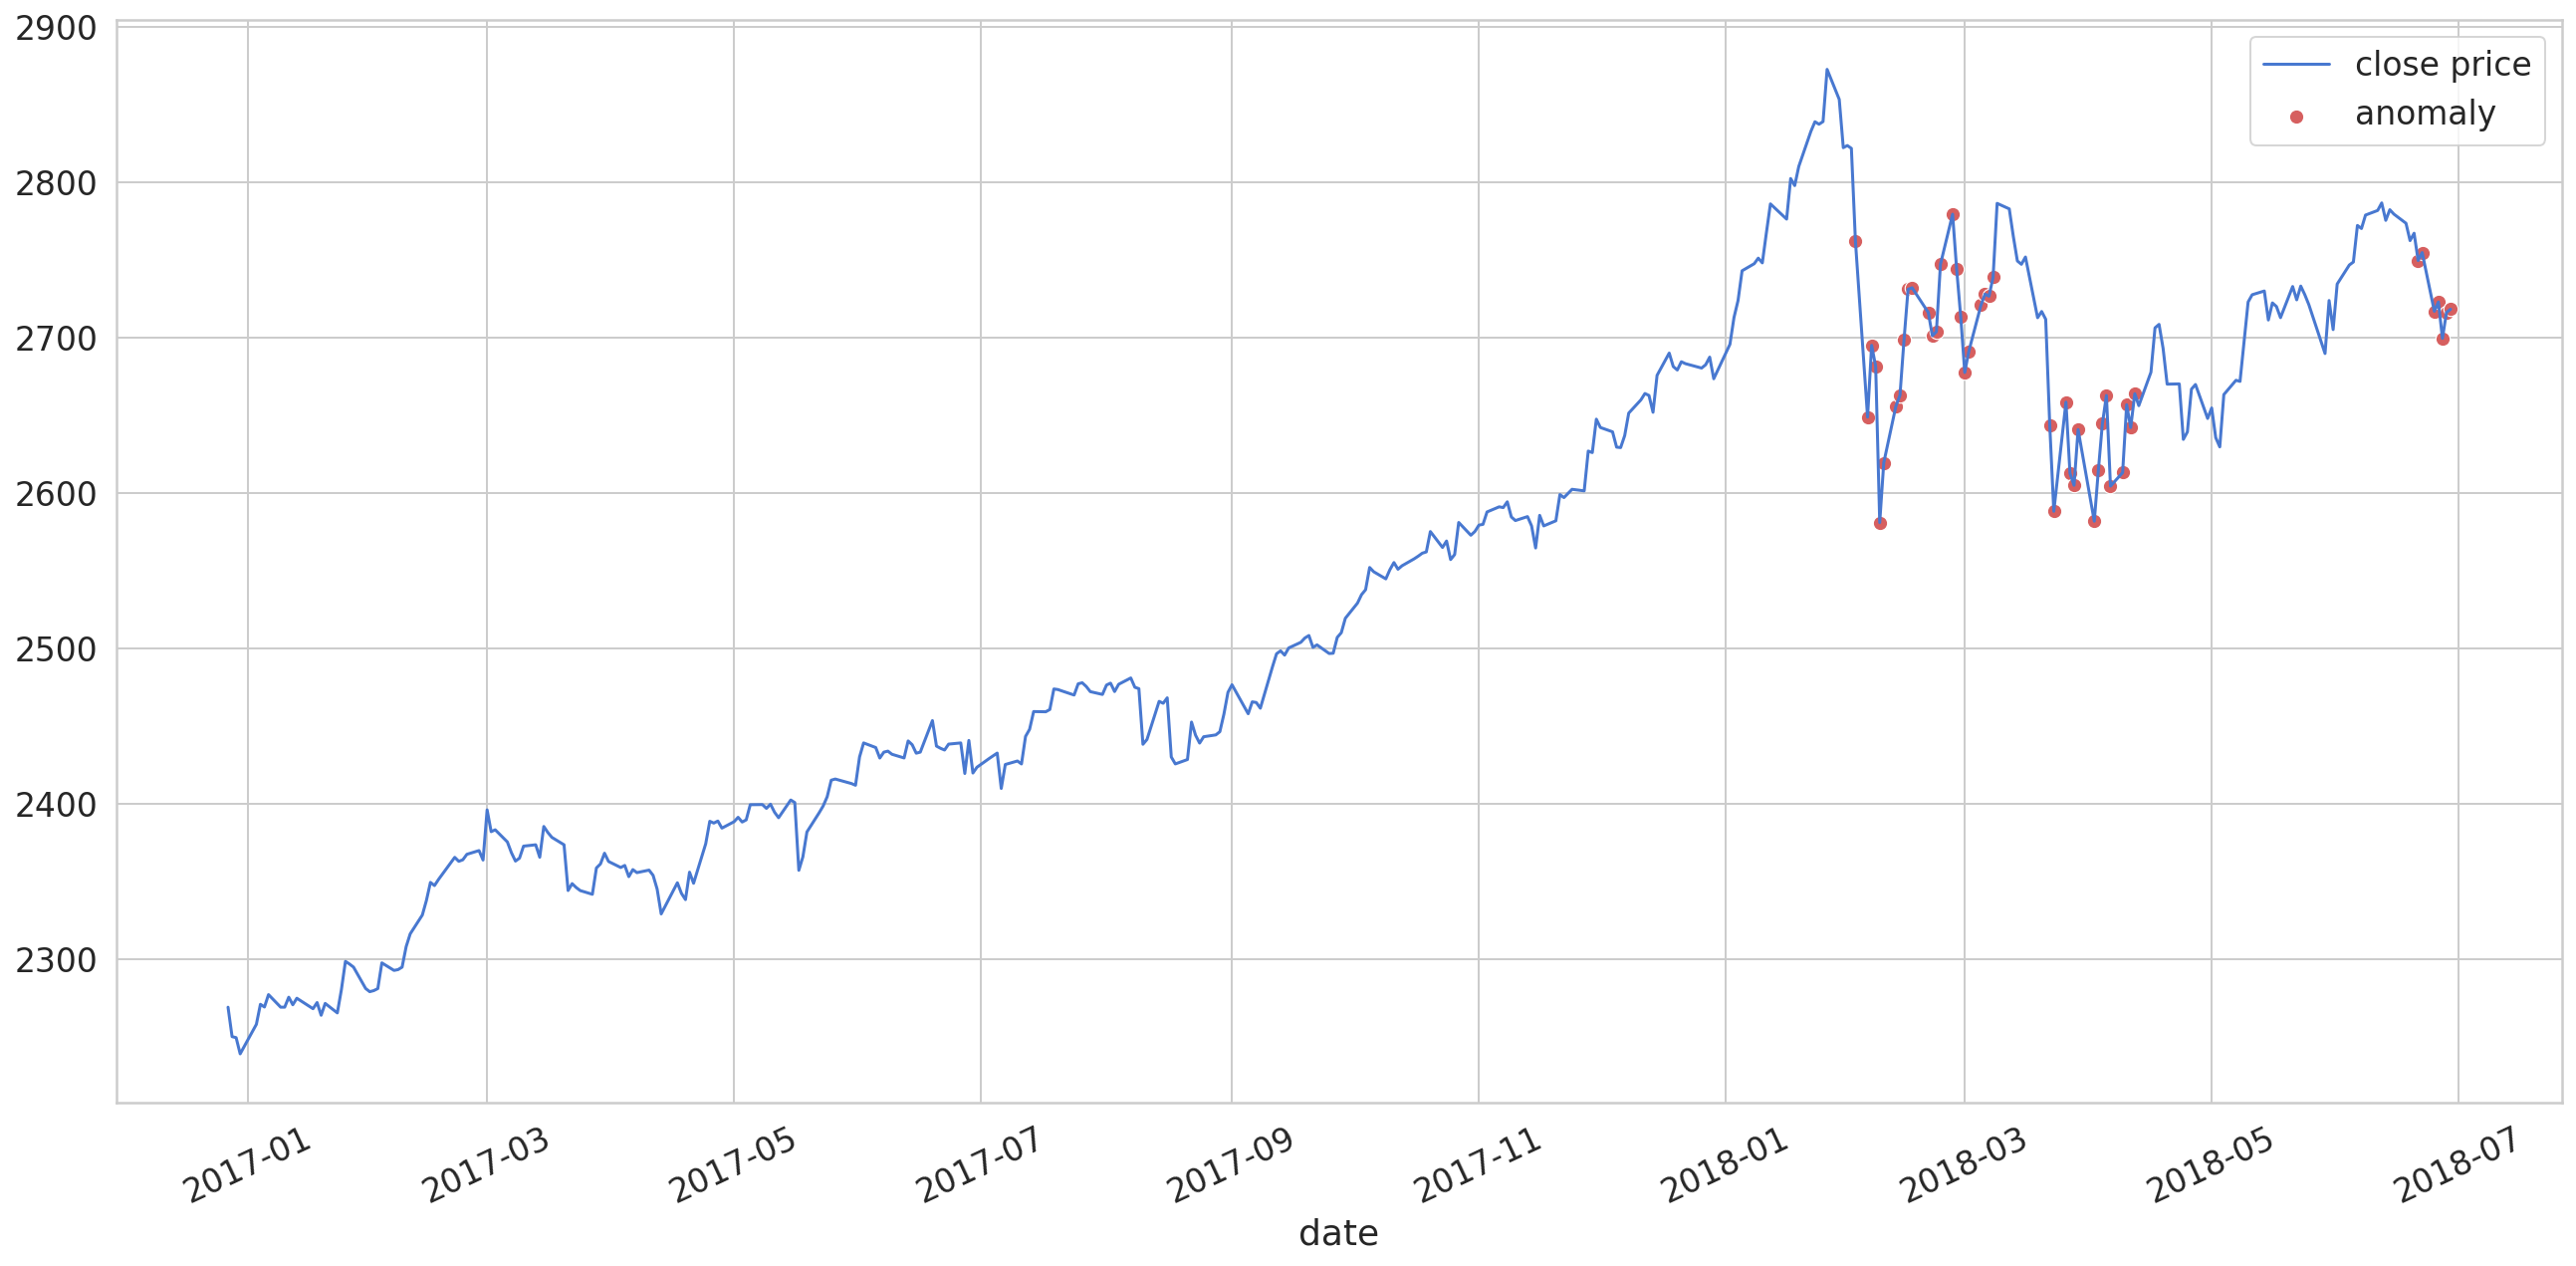

In [149]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close.array.reshape(-1, 1)), 
  label='close price'
);

sns.scatterplot(
  x = anomalies.index,
  y = scaler.inverse_transform(anomalies.close.array.reshape(-1, 1)).flatten(),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();